In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

FIGRATIO = 3 / 5
FIGWIDTH = 10  # inches
FIGHEIGHT = FIGWIDTH * FIGRATIO
FIGSIZE = (FIGWIDTH, FIGHEIGHT)

plt.rcParams.update(
    {
        "axes.labelsize": 12,
        "axes.titlesize": 12,
        "figure.figsize": FIGSIZE,
        "figure.dpi": 300,
        "font.size": 12,
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "text.usetex": True,
    }
)

COLORS = sns.color_palette("Paired")
sns.set_style("ticks")
sns.set_palette(COLORS)

In [ ]:
pd.options.display.float_format = '{:.0f}'.format
SINK_STAGE = 'task::MapBatches(encode_and_upload)'
NUM_BATCHES = 50
BATCH_SIZE = 20

MICROSECOND = 1e6

def process(filename, sink_stage=SINK_STAGE, num_batches=NUM_BATCHES, batch_size=BATCH_SIZE, window_size=5):
    df = pd.read_json(filename)
    start_time = df["ts"].min()
    df = df[df['cat'] == sink_stage]
    df['time_from_start'] = (df['ts'] + df['dur'] - start_time) / MICROSECOND
    df['time_from_start'] = pd.to_timedelta(df['time_from_start'], unit='s')
    df.sort_values('time_from_start', inplace=True)

    df['number_of_rows_finished'] = np.arange(1, num_batches + 1) * batch_size
    df.set_index("time_from_start", inplace=True)
    df["tput"] = df['number_of_rows_finished'].diff() / df.index.total_seconds().diff()
    df['tput'] = df['tput'].fillna(0)

    time_vals = df.index.total_seconds()
    tput_vals = df['tput'].rolling(window=window_size).mean().fillna(0)

    # Postprocessing to fill in 0 values for the beginning
    filled_time_vals = []
    filled_tput_vals = []
    
    for i in np.arange(0, int(time_vals[0]), window_size):
        filled_time_vals.append(i)
        filled_tput_vals.append(0)
    filled_time_vals.extend(time_vals)  
    filled_tput_vals.extend(tput_vals)
    return filled_time_vals, filled_tput_vals


time_radar_dynamic, tput_radar_dynamic = process('../image_generation/raydata/radar-dynamic.json')
time_radar_static, tput_radar_static = process('../image_generation/raydata/radar-static.json')
time_radar_staged, tput_radar_staged = process('../image_generation/raydata/radar-staged.json')
time_radar_fused, tput_radar_fused = process('../image_generation/raydata/radar-fused.json', sink_stage='task::MapBatches(FusedProcessor)', num_batches=10)

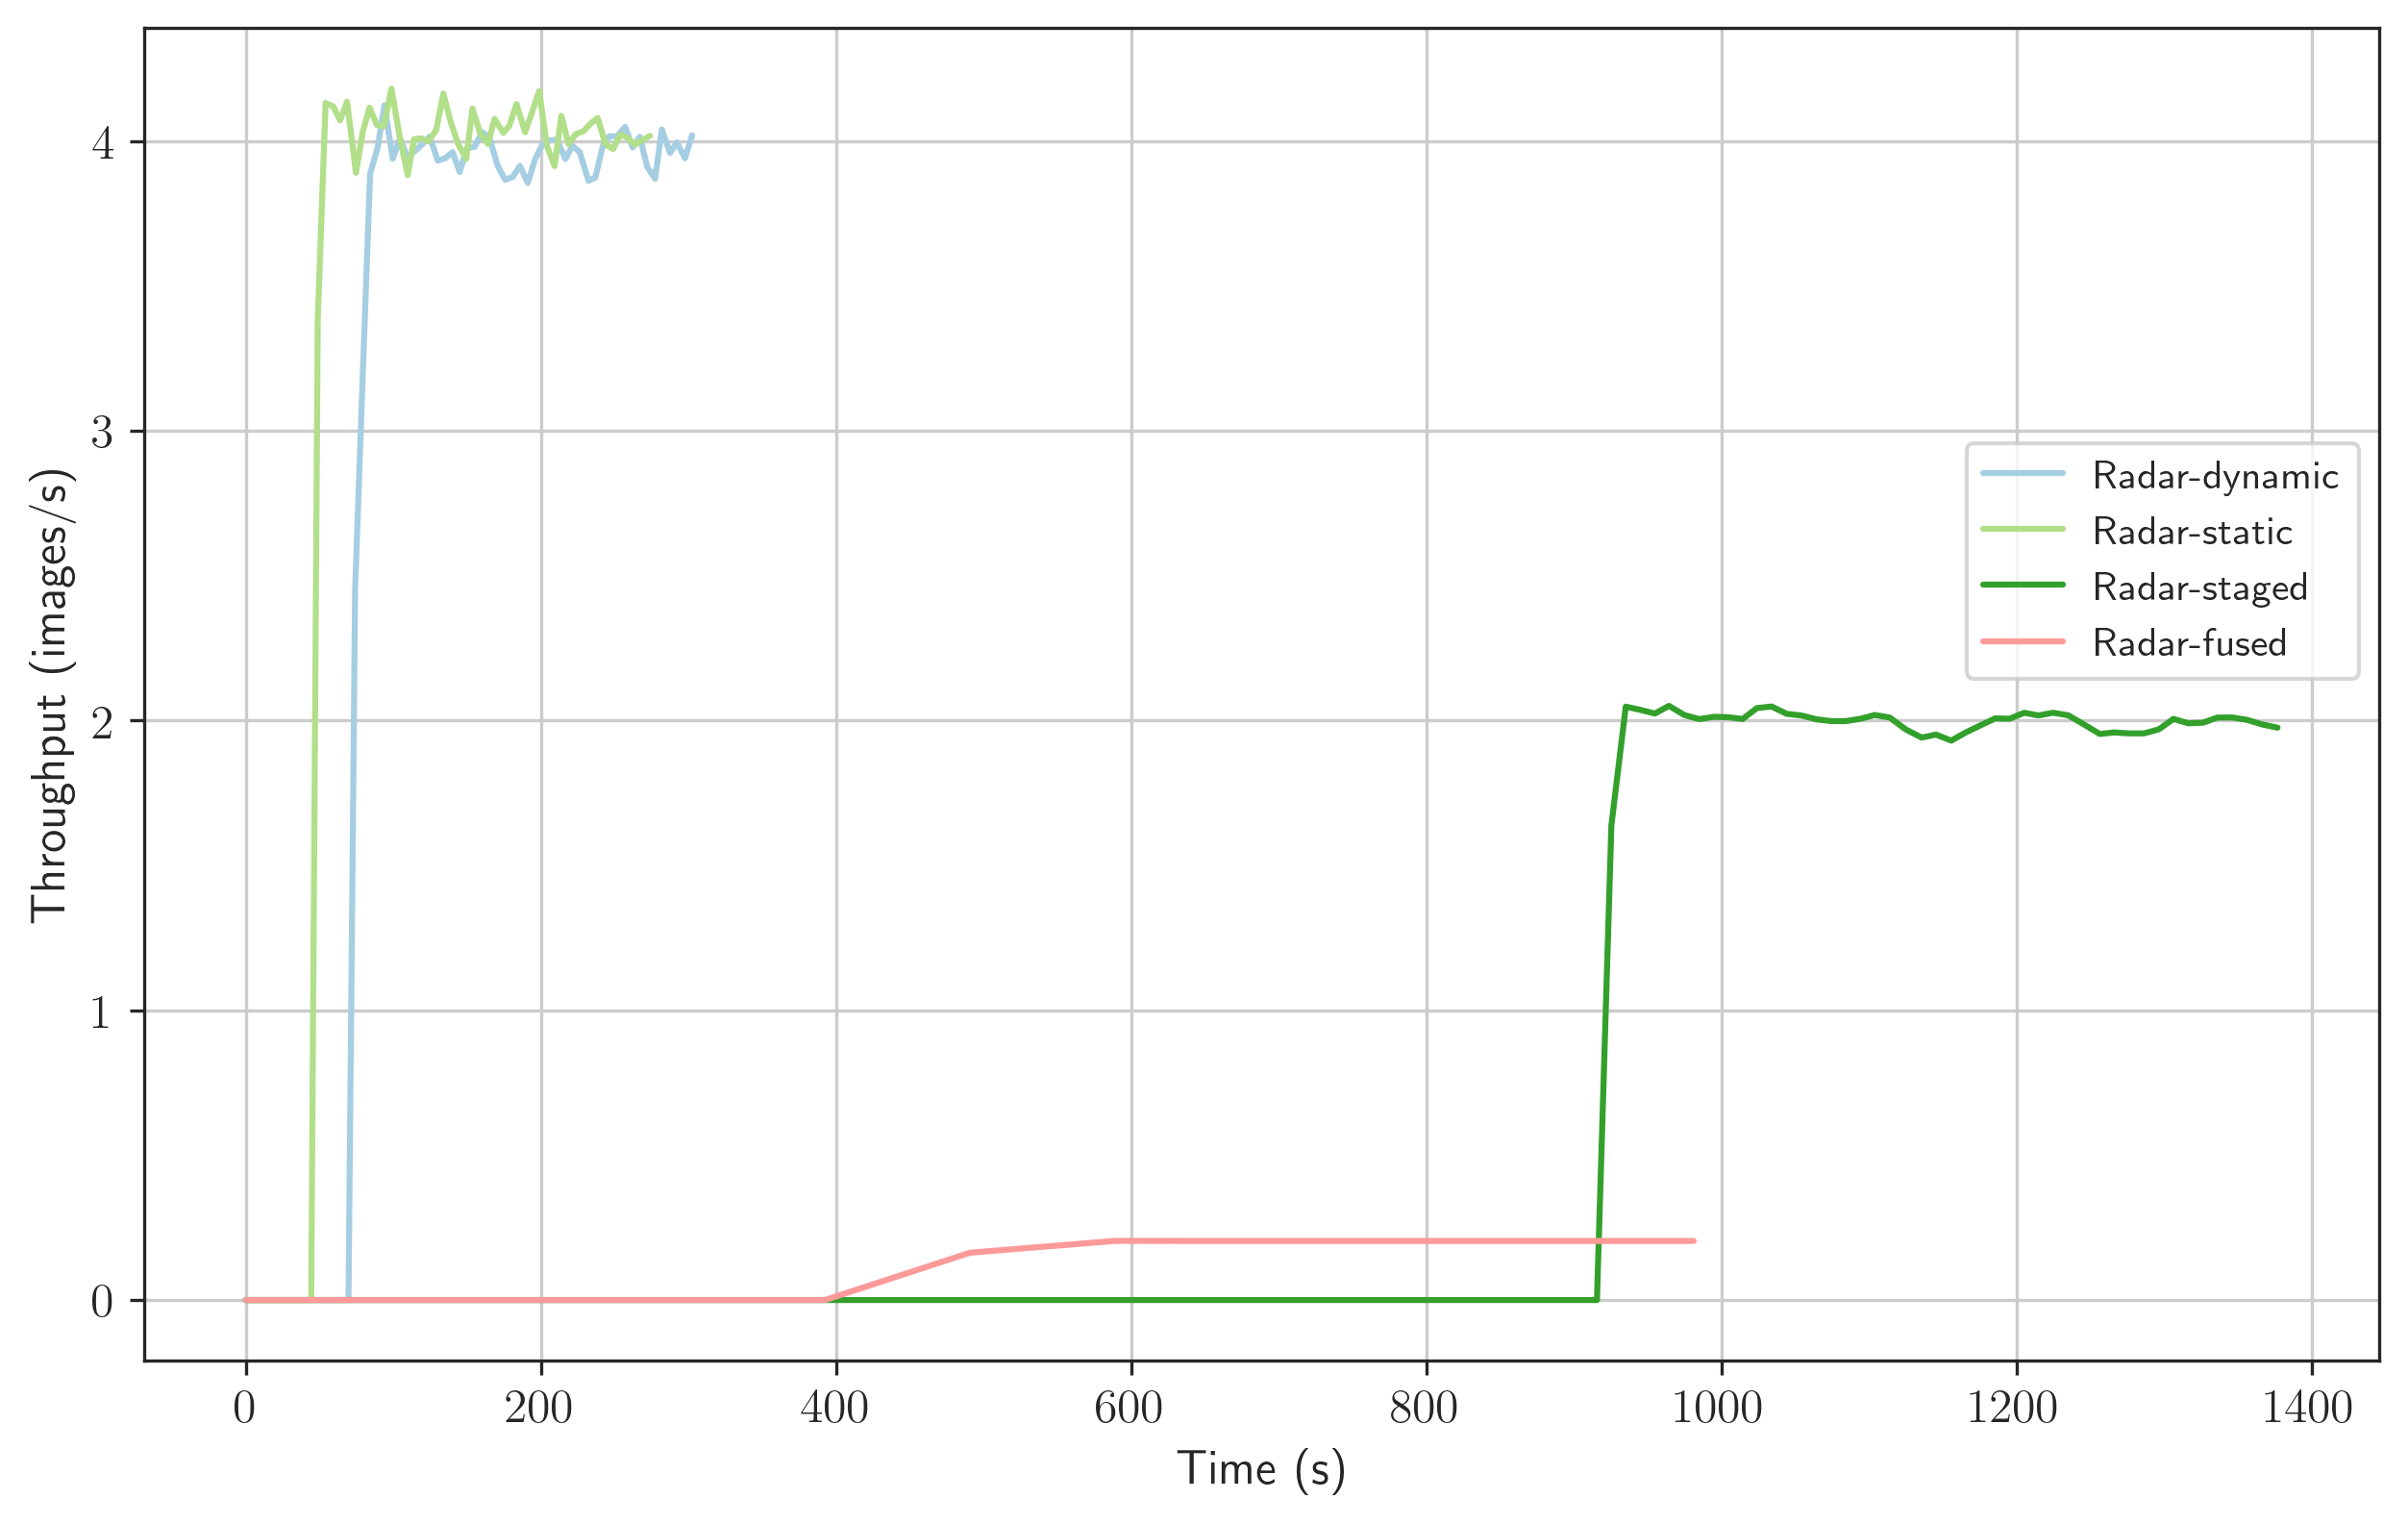

In [154]:
fig, ax = plt.subplots()

ax.plot(time_radar_dynamic, tput_radar_dynamic, label="Radar-dynamic", color=COLORS[0])
ax.plot(time_radar_static, tput_radar_static, label="Radar-static", color=COLORS[2])
ax.plot(time_radar_staged, tput_radar_staged, label="Radar-staged", color=COLORS[3])
ax.plot(time_radar_fused, tput_radar_fused, label="Radar-fused", color=COLORS[4])

plt.xlabel("Time (s)")
plt.ylabel("Throughput (images/s)")
plt.grid(True)
plt.legend(fontsize=10, loc='center right', bbox_to_anchor=(0.5, 0.2, 0.5, 0.8))
plt.show()